# Age Task

## Imports and Random seed

In [30]:
from IPython.display import display
import kagglehub
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
from sklearn.model_selection import StratifiedKFold, KFold, train_test_split
from sklearn.utils.class_weight import compute_class_weight
import torch
from typing import Optional

def set_seed(seed: Optional[int]):
    """
    Set the random seed for reproducibility.

    Args:
        seed (Optional[int]): The seed value to set. If None, no action is taken.
    """
    if seed is None:
        return
    else:
        random.seed(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

set_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## 1. Prepare Dataset

Download via kagglehub

In [2]:
base_path = os.getcwd()
data_path = os.path.join(base_path, "data")
os.environ["KAGGLEHUB_CACHE"] = data_path
path = kagglehub.dataset_download(handle="jangedoo/utkface-new")
path = os.path.join(path, "UTKFace")

print("Path to dataset files:", path)

Path to dataset files: p:\repositories\dlfp_age_task\data\datasets\jangedoo\utkface-new\versions\1\UTKFace


Load the Dataset from local drive `data` to pandas dataframe.

In [3]:
data = []

for file in os.listdir(path):
    try:
        age, gender, race, _ = file.split("_")
    except ValueError:
        age, gender, race = file.split("_")
    img_path = os.path.join(path, file)
    data.append([img_path, int(age)])

df = pd.DataFrame(data, columns=["image_path", "age"])

Display the head of the created DataFrame

In [4]:
df.head()

,image_path,age
0,p:\repositories\dlfp_age_task\data\datasets\ja...,100
1,p:\repositories\dlfp_age_task\data\datasets\ja...,100
2,p:\repositories\dlfp_age_task\data\datasets\ja...,100
3,p:\repositories\dlfp_age_task\data\datasets\ja...,100
4,p:\repositories\dlfp_age_task\data\datasets\ja...,100


## 2. Inspect and normalize the Dataset

Let's start with some insights from the distribution.

                age
count  23708.000000
mean      33.303484
std       19.886112
min        1.000000
25%       23.000000
50%       29.000000
75%       45.000000
max      116.000000


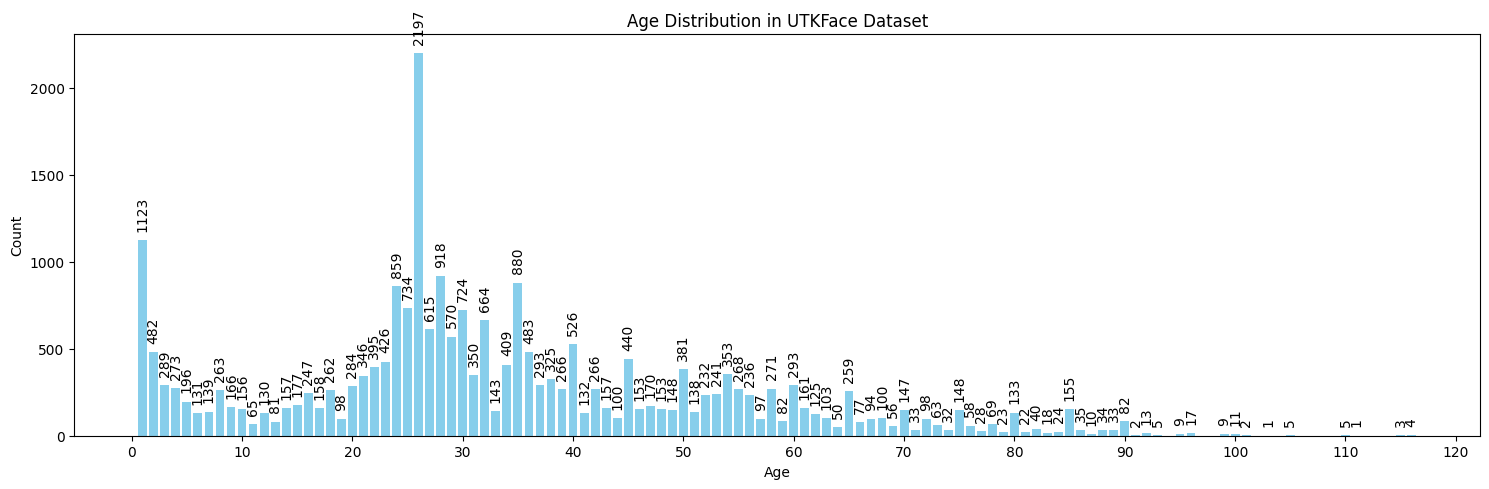

In [5]:
print(df.describe())
# print(df['age'].value_counts().sort_index())  # Check age distribution

unique_ages, age_counts = np.unique(df['age'], return_counts=True)

plt.figure(figsize=(15, 5))
bars = plt.bar(unique_ages, age_counts, color='skyblue') # range(len(unique_ages))
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Age Distribution in UTKFace Dataset')
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 50, int(yval), va='bottom', ha='center', rotation=90)

plt.xticks(np.arange(0, 120.1, 10))
plt.tight_layout()
plt.show()


Now I split the data with StratifiedKFold

In [6]:
# # bins = np.linspace(df['age'].min(), df['age'].max(), 12)

# X_train_val, X_test, y_train_val, y_test = train_test_split(
#     df['image_path'], df['age'], test_size=0.2, random_state=42
# )

# skf = KFold(n_splits=5, shuffle=True, random_state=42)
# folds = skf.split(X_train_val, y_train_val)

# # Visualize all fold distributions
# plt.figure(figsize=(15, 25))

# for fold, (train_index, val_index) in enumerate(folds):
#     train_df = df.iloc[train_index]
#     val_df = df.iloc[val_index]
    
#     # unique_ages_train, age_counts_train = np.unique(train_df['age'], return_counts=True)
#     # unique_ages_val, age_counts_val = np.unique(val_df['age'], return_counts=True)
#     train_dist = train_df['age'].value_counts(normalize=True).sort_index()
#     val_dist = val_df['age'].value_counts(normalize=True).sort_index()

#     # Plot distributions
#     plt.subplot(5, 1, fold + 1)
#     # x = np.arange(len(age_counts))
#     width = 0.35

#     plt.bar(train_dist.index - width/2, train_dist, width, label='Train', color='skyblue')
#     plt.bar(val_dist.index + width/2, val_dist, width, label='Validation', color='salmon')
    
#     plt.xlabel('Age')
#     plt.ylabel('Proportion')
#     plt.title(f'Age Distribution in Fold {fold + 1}')
#     plt.legend()
#     plt.xticks(np.arange(0, 120.1, 10))
#     plt.tight_layout()

# plt.tight_layout()
# plt.show()

                                          image_path  age age_category
1  p:\repositories\dlfp_age_task\data\datasets\ja...  100          60<
2  p:\repositories\dlfp_age_task\data\datasets\ja...  100          60<
4  p:\repositories\dlfp_age_task\data\datasets\ja...  100          60<
5  p:\repositories\dlfp_age_task\data\datasets\ja...  100          60<
6  p:\repositories\dlfp_age_task\data\datasets\ja...  100          60<


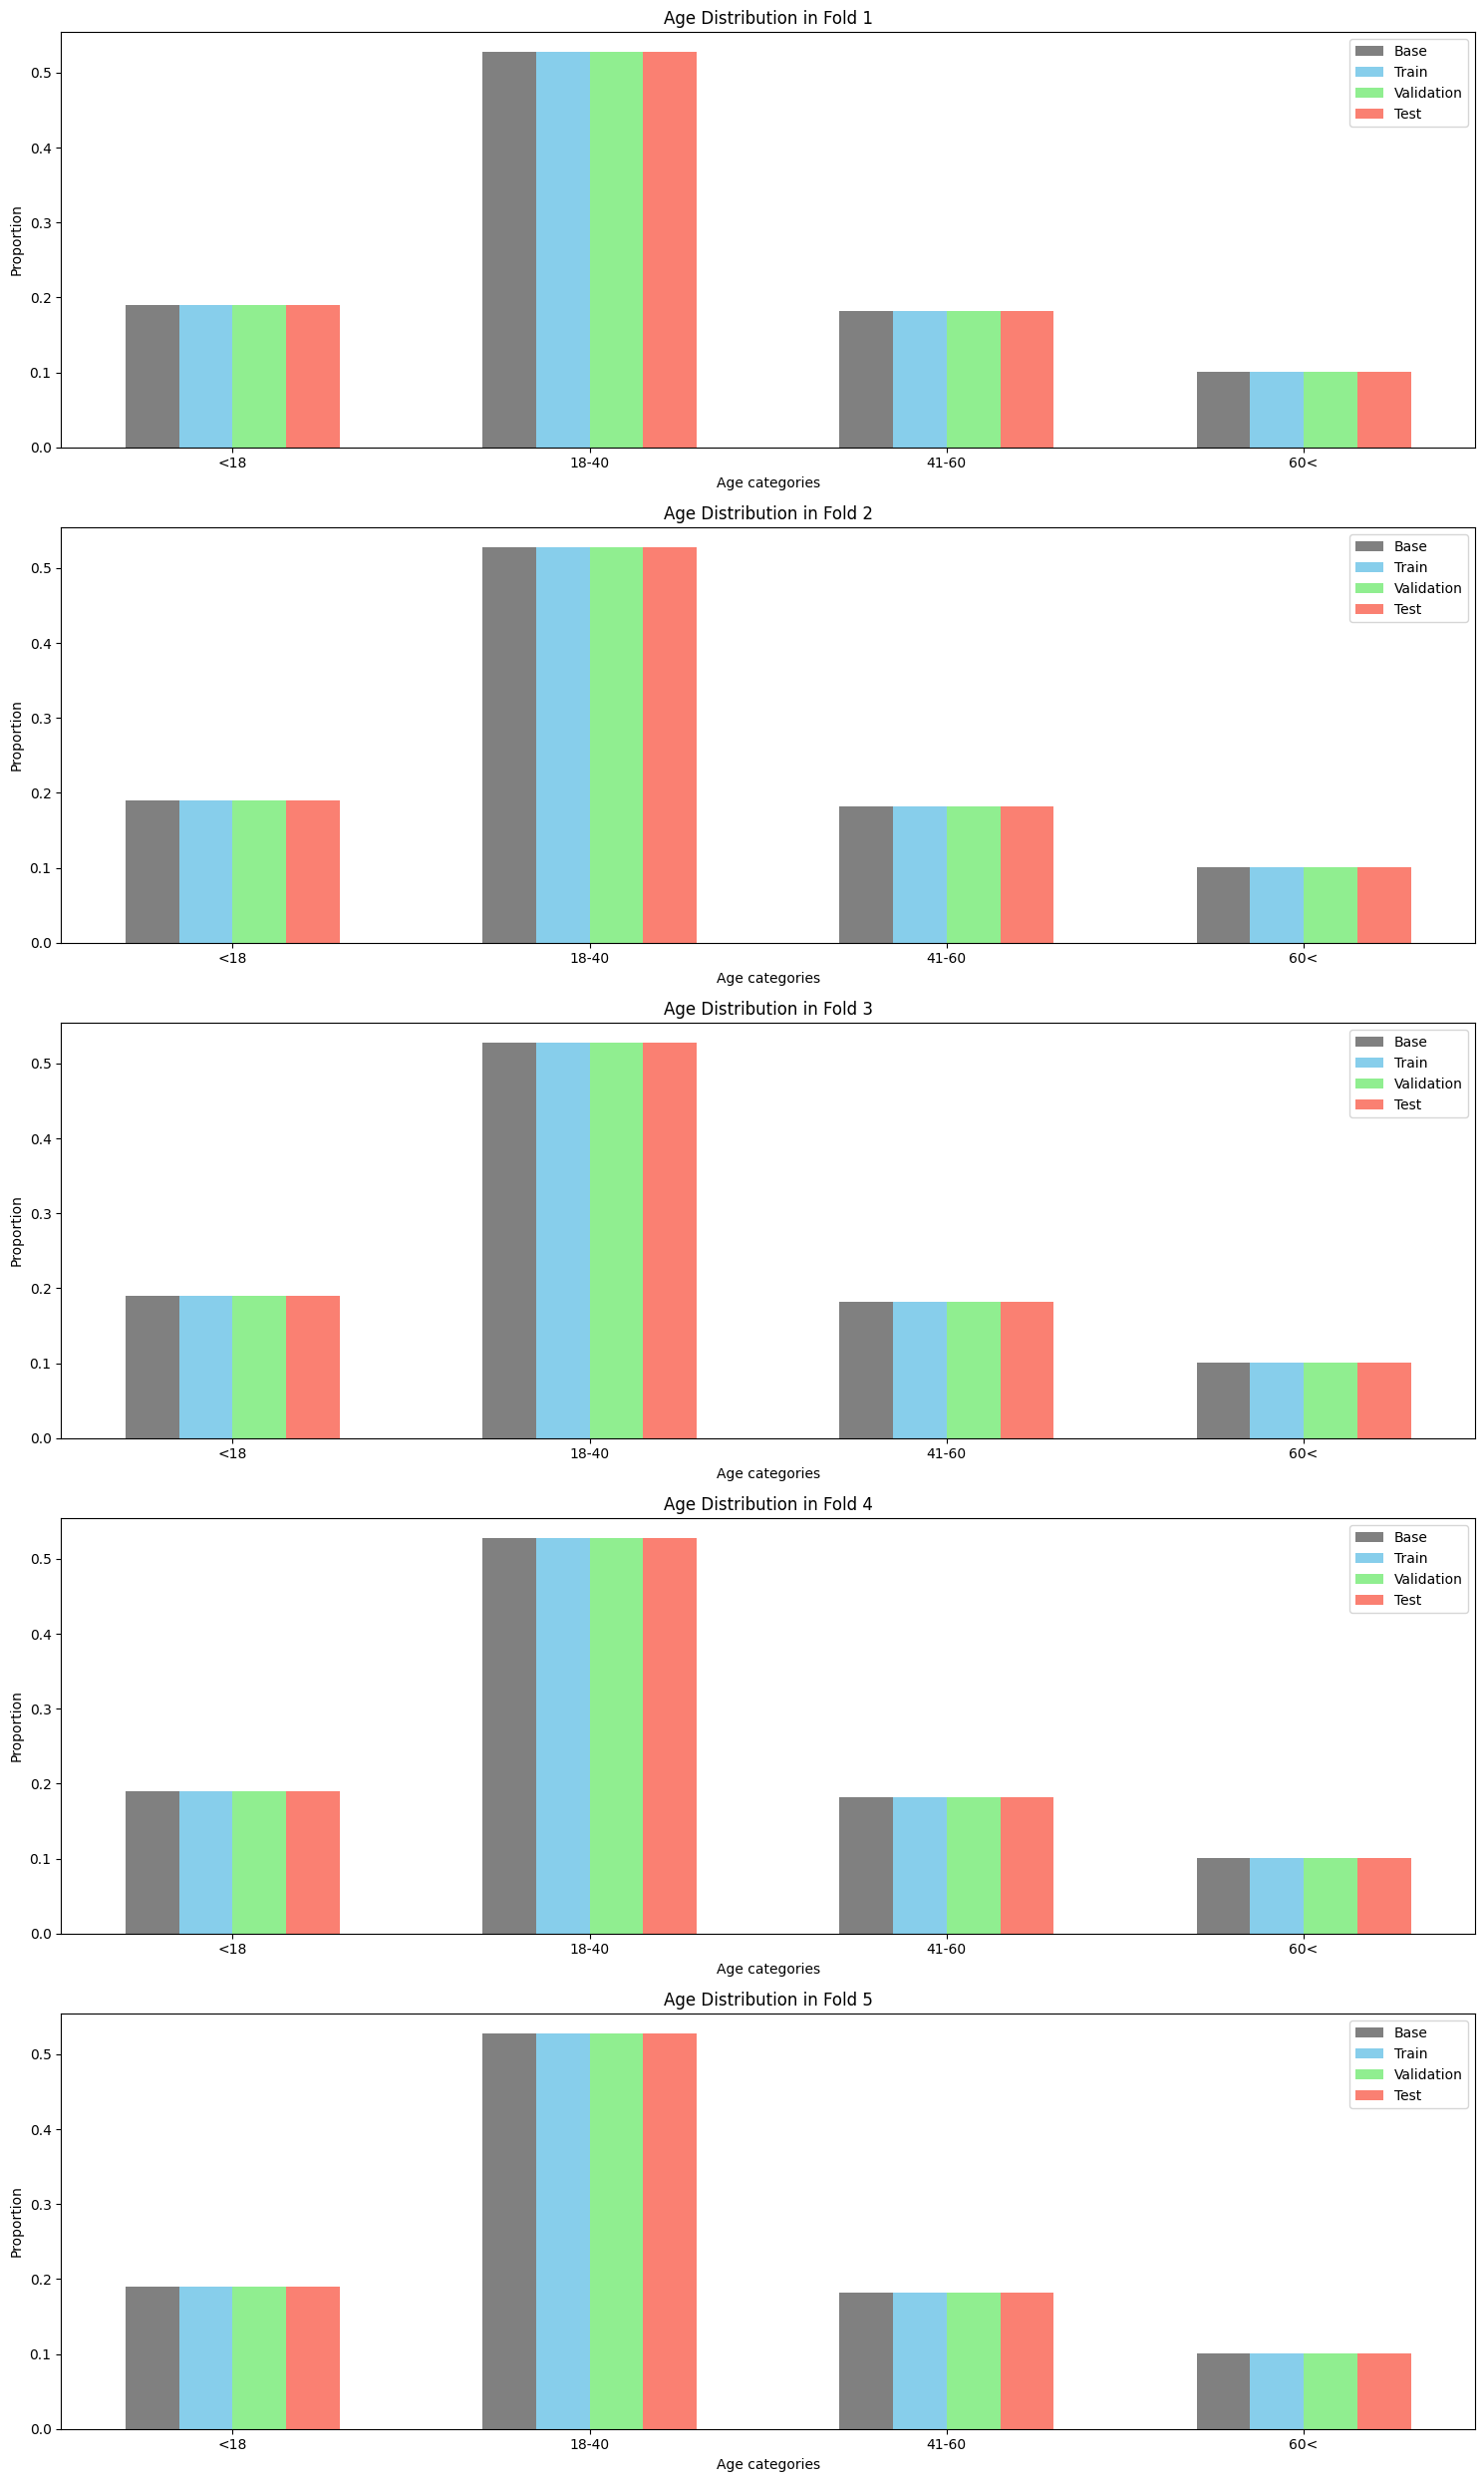

In [ ]:
# Define age categories
bins = [0, 18, 40, 60, np.inf]
labels = ["<18", "18-40", "41-60", "60<"]
df['age_category'] = pd.cut(df['age'], bins=bins, labels=labels)

# Split into Train+Validation and Test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(
    df['image_path'], df['age_category'], test_size=0.2, random_state=42, stratify=df['age_category']
)
test_df = df.loc[df['image_path'].isin(X_test)]

# Prepare data for StratifiedKFold
train_val_df = df.loc[df['image_path'].isin(X_train_val)]
X = train_val_df['image_path']
y = train_val_df['age_category']

# Further split Train+Validation into Train and Validation sets with StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
folds = skf.split(X, y)

# Prepare to visualize all fold distributions
plt.figure(figsize=(15, 25))

for fold, (train_index, val_index) in enumerate(folds):
    train_df = train_val_df.iloc[train_index]
    val_df = train_val_df.iloc[val_index]
    
    # Calculate proportions for each age category
    base_dist = df['age_category'].value_counts(normalize=True).sort_index()
    test_dist = test_df['age_category'].value_counts(normalize=True).sort_index()
    train_dist = train_df['age_category'].value_counts(normalize=True).sort_index()
    val_dist = val_df['age_category'].value_counts(normalize=True).sort_index()

    # Plot distributions
    plt.subplot(5, 1, fold + 1)
    width = 0.15
    x = np.arange(len(train_dist))

    plt.bar(x - 1.5 * width, train_dist, width, label='Base', color='grey')
    plt.bar(x - width/2, val_dist, width, label='Train', color='skyblue')
    plt.bar(x + width/2, test_dist, width, label='Validation', color='lightgreen')
    plt.bar(x + 1.5 * width, train_dist, width, label='Test', color='salmon')
    
    plt.xlabel('Age categories')
    plt.ylabel('Proportion')
    plt.title(f'Age Distribution in Fold {fold + 1}')
    plt.legend()
    plt.xticks(x, train_dist.index.astype(str))
    plt.tight_layout()

plt.tight_layout()
plt.show()

Add class weights because of imbalance in the age categories.

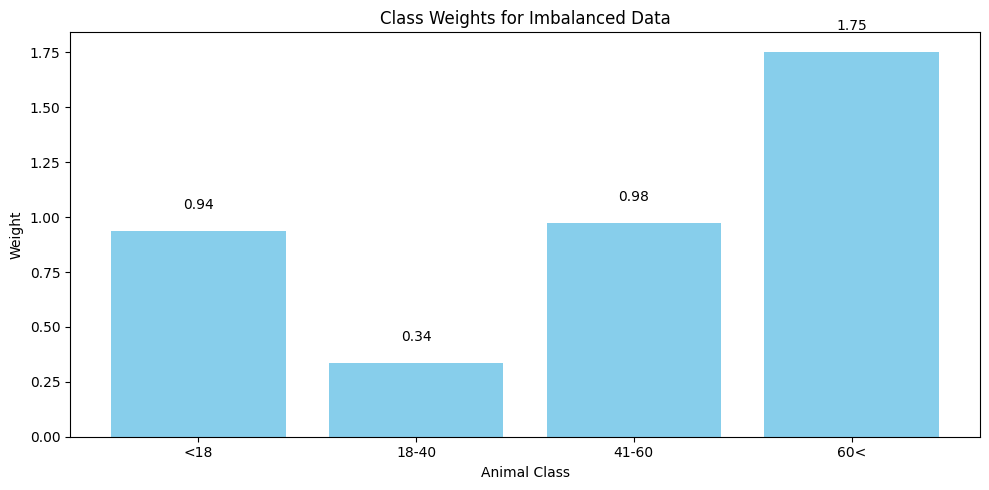

Class weights tensor: tensor([0.9351, 0.3361, 0.9751, 1.7536], device='cuda:0')


In [31]:
# Get the unique classes
classes = np.unique(df['age_category'])
num_classes = len(classes)

# # Compute class weights
# class_weights = compute_class_weight(
#     class_weight='balanced',
#     classes=classes,
#     y=df['age_category']
# )

# Calculate class weights inversely proportional to class frequencies
class_counts = df['age_category'].value_counts().sort_index().values
class_weights = 1. / class_counts
class_weights = class_weights / np.sum(class_weights) * num_classes  # Normalize

# Display weights
plt.figure(figsize=(10, 5))
bars = plt.bar(range(len(labels)), class_weights, color='skyblue')
plt.xticks(range(len(labels)), labels)
plt.xlabel('Animal Class')
plt.ylabel('Weight')
plt.title('Class Weights for Imbalanced Data')

# Add weight values above bars
for i, (weight, bar) in enumerate(zip(class_weights, bars)):
    plt.text(i, weight + 0.1, f'{weight:.2f}', ha='center')

plt.tight_layout()
plt.show()

# Convert class weights to a pytorch tensor
class_weights_tensor = torch.FloatTensor(class_weights).to(device)
print("Class weights tensor:", class_weights_tensor)

# Use the class weights in your loss function
loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights_tensor)